In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.calibration import LabelEncoder


In [62]:
xls_paths = ['Data/expedia_results - 14.03.2025.csv',
             'Data/expedia_results - 16.03.2025.csv',
             'Data/expedia_results - 18.03.2025.csv']

combined_df = pd.DataFrame()
for xls_path in xls_paths:
    df = pd.read_csv(xls_path)
    df = df[df['TTT'] != 0]
    df['search_group'] = range(len(df))
    df['search_group'] = df['search_group'] % 100
    display(df.head(3))
    combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df.to_csv('Data/combined_expedia_results.csv', index=False)
print(f"total rows in combined: {len(combined_df)}")


,Snapshot Date,TTT,LOS,Hotel Name,Price,Rating,Reviews,Neighborhood,Breakfast,Free Cancellation,Rooms Left,Check-in,Check-out,search_group
303,2025-03-14,1,1,Courtyard New York Manhattan/ Midtown East,345.0,Excellent,"2,243",New York,No,No,5.0,2025-03-15,2025-03-16,0
304,2025-03-14,1,1,Millennium Premier New York Times Square,342.0,Good,"1,004",Theater District,Yes,No,NaN,2025-03-15,2025-03-16,1
305,2025-03-14,1,1,"PUBLIC, an Ian Schrager hotel",635.0,Very,"2,809",New York,No,No,NaN,2025-03-15,2025-03-16,2


,Snapshot Date,TTT,LOS,Hotel Name,Price,Rating,Reviews,Neighborhood,Breakfast,Free Cancellation,Rooms Left,Check-in,Check-out,search_group
500,2025-03-16,1,1,TownePlace Suites by Marriott New York Brooklyn,283,Fully,264,Brooklyn,Yes,Yes,2.0,2025-03-17,2025-03-18,0
501,2025-03-16,1,1,Hotel 32 32,309,Very,"2,043",New York,No,No,89.0,2025-03-17,2025-03-18,1
502,2025-03-16,1,1,"PUBLIC, an Ian Schrager hotel",589,Very,"2,815",New York,No,No,NaN,2025-03-17,2025-03-18,2


,Snapshot Date,TTT,LOS,Hotel Name,Price,Rating,Reviews,Neighborhood,Breakfast,Free Cancellation,Rooms Left,Check-in,Check-out,search_group
500,2025-03-18,1,1,Hotel 32 32,372,Very,"2,045",New York,No,No,109.0,2025-03-19,2025-03-20,0
501,2025-03-18,1,1,DoubleTree by Hilton New York Times Square West,427,Fully,"1,829",New York,No,Yes,NaN,2025-03-19,2025-03-20,1
502,2025-03-18,1,1,"PUBLIC, an Ian Schrager hotel",841,Very,"2,817",New York,No,No,NaN,2025-03-19,2025-03-20,2


total rows in combined: 45000


In [63]:
# Hotels ratings correction
def correct_ratings(df):
    # List of valid ratings
    valid_ratings = ['Excellent', 'Very', 'Good', 'Exceptional','Wonderful']
    
    # Function to check if a rating is valid
    def is_valid_rating(rating):
        return str(rating).strip() in valid_ratings
    
    # Group by hotel name and find hotels with mixed ratings
    def process_hotel_ratings(hotel_group):
        # Check if the group has any valid ratings
        valid_ratings_in_group = hotel_group[hotel_group['Rating'].apply(is_valid_rating)]
        
        # If there are valid ratings, replace invalid ones
        if not valid_ratings_in_group.empty:
            # Get the most common valid rating for this hotel
            most_common_rating = valid_ratings_in_group['Rating'].mode().iloc[0]
            
            # Replace 'fully' and 'reserve' with the most common valid rating
            hotel_group.loc[~hotel_group['Rating'].apply(is_valid_rating), 'Rating'] = most_common_rating
        
        return hotel_group
    
    # Apply the correction to each hotel group
    corrected_df = df.groupby('Hotel Name', group_keys=False).apply(process_hotel_ratings)
    
    return corrected_df

# Apply the correction
combined_df = correct_ratings(combined_df)

# Replace 'Very' rating with 'Very Good'
combined_df['Rating'] = combined_df['Rating'].replace('Very', 'Very Good')



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10260\4164562101.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrected_df = df.groupby('Hotel Name', group_keys=False).apply(process_hotel_ratings)


Text(0, 0.5, 'Frequency')

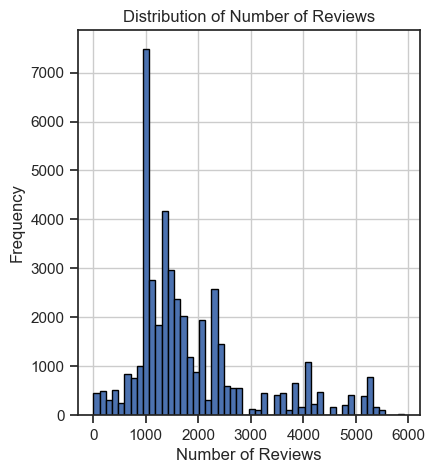

In [64]:
# Distribution of Number of Review
combined_df['Reviews'] = combined_df['Reviews'].str.replace(',', '').astype(float)
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
combined_df['Reviews'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Excellent'),
  Text(1, 0, 'Very Good'),
  Text(2, 0, 'Wonderful'),
  Text(3, 0, 'Good'),
  Text(4, 0, 'Exceptional')])

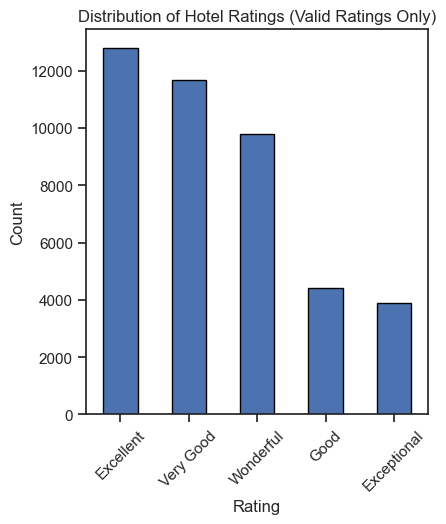

In [65]:
# Distribution of Hotel Ratings (excluding 'Fully' and 'Reserve')
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)

# Filter out 'Fully' and 'Reserve' ratings
valid_ratings = combined_df[~combined_df['Rating'].isin(['Fully', 'Reserve'])]

# Plot the filtered ratings
valid_ratings['Rating'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Hotel Ratings (Valid Ratings Only)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)

Text(0, 0.5, 'Frequency')

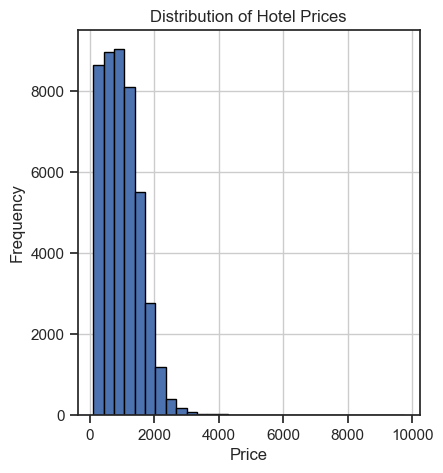

In [66]:
# Distribution of Prices
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 3)
combined_df['Price'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Hotel Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

In [67]:
# Remove outliers based on Price using Tukey method (1.5 IQR)
def remove_price_outliers(df):
    # Calculate Q1, Q3, and IQR for Price
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Price statistics before removing outliers:")
    print(f"Number of hotels: {len(df)}")
    print(f"Price range: ${df['Price'].min()} - ${df['Price'].max()}")
    print(f"Q1: ${Q1}, Q3: ${Q3}, IQR: ${IQR}")
    print(f"Lower bound: ${lower_bound}, Upper bound: ${upper_bound}")
    
    # Identify outliers
    outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
    print(f"Number of outliers identified: {len(outliers)} ({len(outliers)/len(df)*100:.2f}% of data)")
    
    # Filter out the outliers
    df_filtered = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]
    
    print(f"Price statistics after removing outliers:")
    print(f"Number of hotels: {len(df_filtered)}")
    print(f"Price range: ${df_filtered['Price'].min()} - ${df_filtered['Price'].max()}")
    
    return df_filtered

# Apply the outlier removal function to combined_df
combined_df = remove_price_outliers(combined_df)


Price statistics before removing outliers:
Number of hotels: 45000
Price range: $106.0 - $9753.0
Q1: $533.0, Q3: $1350.0, IQR: $817.0
Lower bound: $-692.5, Upper bound: $2575.5
Number of outliers identified: 482 (1.07% of data)
Price statistics after removing outliers:
Number of hotels: 44518
Price range: $106.0 - $2575.0


In [68]:
# Define ordinal mapping for ratings
rating_map = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
    'Exceptional': 5,
    'Fully': -1,
    'Reserve': -1
}

# Convert Rating column itself to numeric values
combined_df['Rating'] = combined_df['Rating'].map(rating_map)
# Handle NaN values by filling them with 0
combined_df['Rating'] = combined_df['Rating'].fillna(0)

# Display the first few rows to verify the changes
combined_df.head()

,Snapshot Date,TTT,LOS,Hotel Name,Price,Rating,Reviews,Neighborhood,Breakfast,Free Cancellation,Rooms Left,Check-in,Check-out,search_group
0,2025-03-14,1,1,Courtyard New York Manhattan/ Midtown East,345.0,3.0,2243.0,New York,No,No,5.0,2025-03-15,2025-03-16,0
1,2025-03-14,1,1,Millennium Premier New York Times Square,342.0,1.0,1004.0,Theater District,Yes,No,NaN,2025-03-15,2025-03-16,1
2,2025-03-14,1,1,"PUBLIC, an Ian Schrager hotel",635.0,2.0,2809.0,New York,No,No,NaN,2025-03-15,2025-03-16,2
3,2025-03-14,1,1,Residence Inn by Marriott New York Manhattan/M...,268.0,4.0,1001.0,New York,Yes,No,5.0,2025-03-15,2025-03-16,3
4,2025-03-14,1,1,Hyatt Place New York City/Times Square,255.0,2.0,2435.0,New York,Yes,No,NaN,2025-03-15,2025-03-16,4


In [ ]:
# Breakfast: No=0, Yes=1
combined_df['Breakfast'] = (combined_df['Breakfast'] == 'Yes').astype(int)

# Free Cancellation: No=0, Yes=1
combined_df['Free Cancellation'] = (combined_df['Free Cancellation'] == 'Yes').astype(int)

# Hotels names alphabetical order coding
hotel_names = sorted(combined_df['Hotel Name'].unique())
hotel_name_map = {name: idx for idx, name in enumerate(hotel_names)}
combined_df['Hotel Name'] = combined_df['Hotel Name'].map(hotel_name_map)

# Check unique neighborhoods dataset in order to sort them
unique_neighborhoods = sorted(combined_df['Neighborhood'].dropna().unique())
print("Unique neighborhoods in dataset:")
for i, neighborhood in enumerate(unique_neighborhoods):
    print(f"{i+1}. {neighborhood}")




Unique neighborhoods in dataset:
1. Brooklyn
2. Central New York City
3. Chelsea
4. Downtown Brooklyn
5. Entire apartment
6. Entire home
7. Flushing
8. Greenwich Village
9. Jersey City
10. Long Island City
11. New York
12. Queens
13. SoHo
14. Staten Island
15. Theater District
16. Upper West Side
17. Williamsburg


In [ ]:
# Create 1-16 ranking based on tourist desirability (16 = best location)
nyc_neighborhood_ranking = {
    # Top tier tourist locations
    'Theater District': 16,       
    'Central New York City': 15,  
    'New York': 14,               
    
    # Very desirable central locations
    'Times Square': 13,           
    'SoHo': 12,                   
    'Chelsea': 11,                
    'Greenwich Village': 10,      
    
    # Good locations, slightly less central
    'Upper West Side': 9,        
    
    # Brooklyn prime areas
    'Downtown Brooklyn': 8,      
    'Williamsburg': 7,          
    
    # Queens good areas
    'Long Island City': 6,      
    
    # Generic borough designations
    'Brooklyn': 5,              
    'Queens': 4,                
    
    # Further areas
    'Flushing': 3,              
    'Jersey City': 2,           
    'Staten Island': 1,         
    
    # Non-neighborhoods and Unknown set to -1
    'Entire apartment': -1,
    'Entire home': -1,
    'Unknown': -1
}

# Fill NaN values with "Unknown" first so we can map them
combined_df['Neighborhood'] = combined_df['Neighborhood'].fillna("Unknown")

# Apply the ranking - IMPORTANT: handle missing values immediately
combined_df['Neighborhood'] = combined_df['Neighborhood'].map(nyc_neighborhood_ranking).fillna(-1)

# Now it's safe to convert to int
combined_df['Neighborhood'] = combined_df['Neighborhood'].astype(int)

# Replace all other NaN values with -1
combined_df = combined_df.fillna(-1)

# Check distribution of neighborhoods after mapping
neighborhood_counts = combined_df['Neighborhood'].value_counts(dropna=False).sort_index()
print("Distribution of neighborhood values:")
print(neighborhood_counts)

# save all changes
combined_df.to_csv('Data/combined_expedia_results.csv', index=False)




Distribution of neighborhood values:
Neighborhood
-1        12
 1        14
 2        18
 3         2
 4       122
 5       752
 6         2
 7       164
 8       112
 9       535
 10      159
 11     3372
 12       89
 14    28750
 15     2485
 16     7930
Name: count, dtype: int64


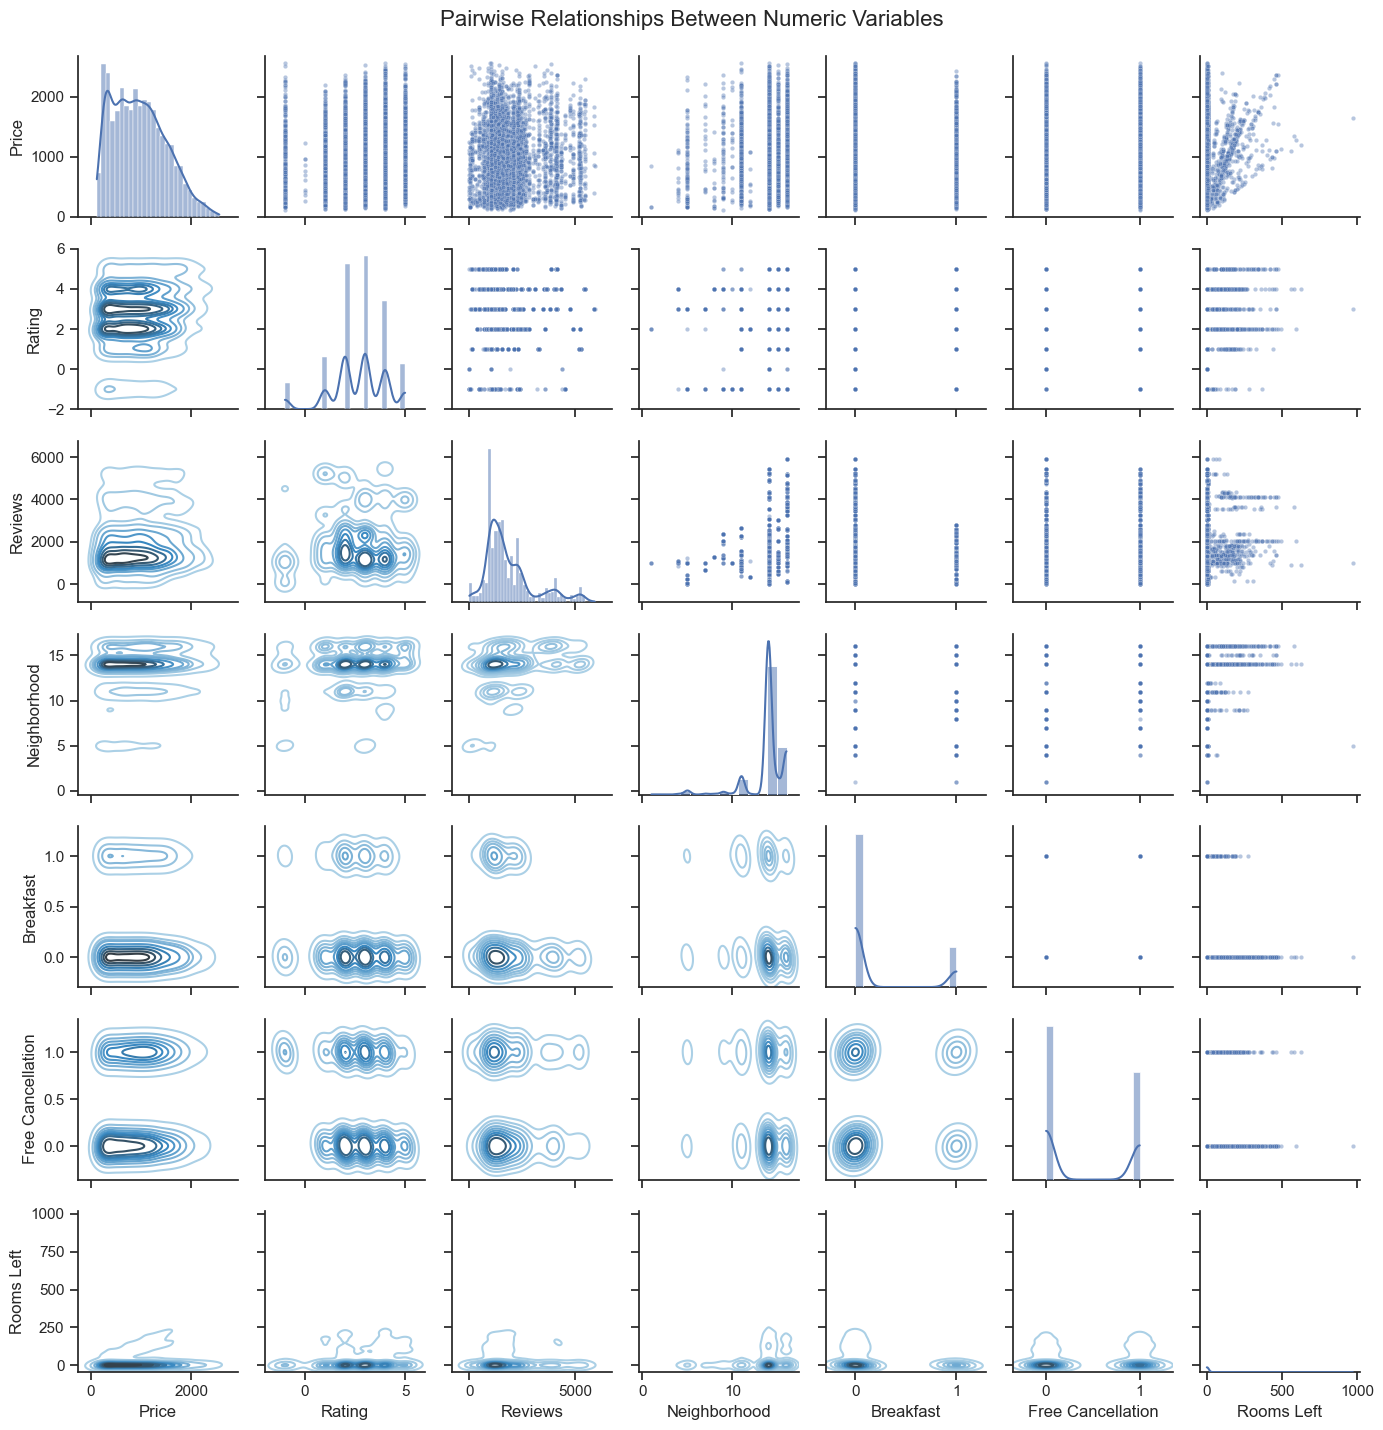

In [71]:
# Create a PairGrid with scatter plots for numeric columns
# Set the style of the visualization
sns.set(style="ticks", color_codes=True)

# Select only the numeric columns for the PairGrid
numeric_cols = ['Price', 'Rating', 'Reviews', 'Neighborhood', 'Breakfast', 'Free Cancellation', 'Rooms Left']

# Create a subset of the data to avoid overcrowding the plot
# Using a sample of 5000 rows for better visualization
sample_size = 5000
df_sample = combined_df[numeric_cols].sample(n=min(sample_size, len(combined_df)), random_state=42)

# Create the PairGrid
g = sns.PairGrid(df_sample, diag_sharey=False, height=2)

# Map different visualizations to upper, lower, and diagonal subplots
g.map_upper(sns.scatterplot, alpha=0.4, s=10)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.histplot, kde=True)

# Adjust the layout and title
plt.tight_layout()
plt.suptitle('Pairwise Relationships Between Numeric Variables', y=1.02, fontsize=16)

# Show the plot
plt.show()

## Key Relationships with Price

- **Reviews and Price:** There's a positive relationship between the number of reviews and price—hotels with more reviews tend to be more expensive. This may indicate that more popular or well-established properties command higher prices.

- **Rating and Price:** There's a correlation between rating and price, with higher-rated hotels generally charging more. The vertical striping pattern shows that certain rating categories (like 4-5 stars) have wider price ranges than others.

- **Neighborhood and Price:** The neighborhood coding (-1 to 16) shows some relationship with price, with certain neighborhood codes having higher average prices. More desirable areas appear to command premium pricing.

- **Rooms Left and Price:** There's an interesting relationship where lower inventory (fewer rooms left) tends to correlate with higher prices, supporting the dynamic pricing model hotels use.

- **Breakfast and Price:** Hotels offering breakfast (value 1) show a slight price premium compared to those without (value 0), but the difference isn't dramatic.

- **Free Cancellation and Price:** There's minimal difference in pricing based on cancellation policies, suggesting this feature isn't a major price driver.
